### **Step 1: Load and Process Data**

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Path to dataset
dataset_path = "fashion"

# Get list of categories
categories = os.listdir(dataset_path)
print("Categories:", categories)

# Prepare storage for images and labels
image_data = []
labels = []

# Set image size for consistency
image_size = (64, 64)

Categories: ['ankleboot', 'bag', 'coat', 'dress', 'pullover', 'sandal', 'shirt', 'sneaker', 'trouser', 'tshirt-top']


In [3]:
# Load images and store first 5 images for visualization
sample_images = {category: [] for category in categories}

for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    # Track number of images processed per category
    count = 0 
    
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)

        # Open, resize, and convert image to grayscale
        img = Image.open(image_path).convert("L")
        img = img.resize(image_size)
        # Flatten image into 1D array
        img_array = np.array(img).flatten()  

        # Store the image data and corresponding label
        image_data.append(img_array)
        labels.append(label)

        # Store sample images (only first 5 per category)
        if count < 5:
            sample_images[category].append(np.array(img))  # Store raw image for display
            count += 1

In [4]:
# Convert to NumPy arrays
X = np.array(image_data)
y = np.array(labels)

# Tests
print(f"Number of images and pixel size: {X.shape}")
print(f"Number of labels: {y.shape}")
print(f"Number of catagories: {len(categories)}")

Number of images and pixel size: (70000, 4096)
Number of labels: (70000,)
Number of catagories: 10


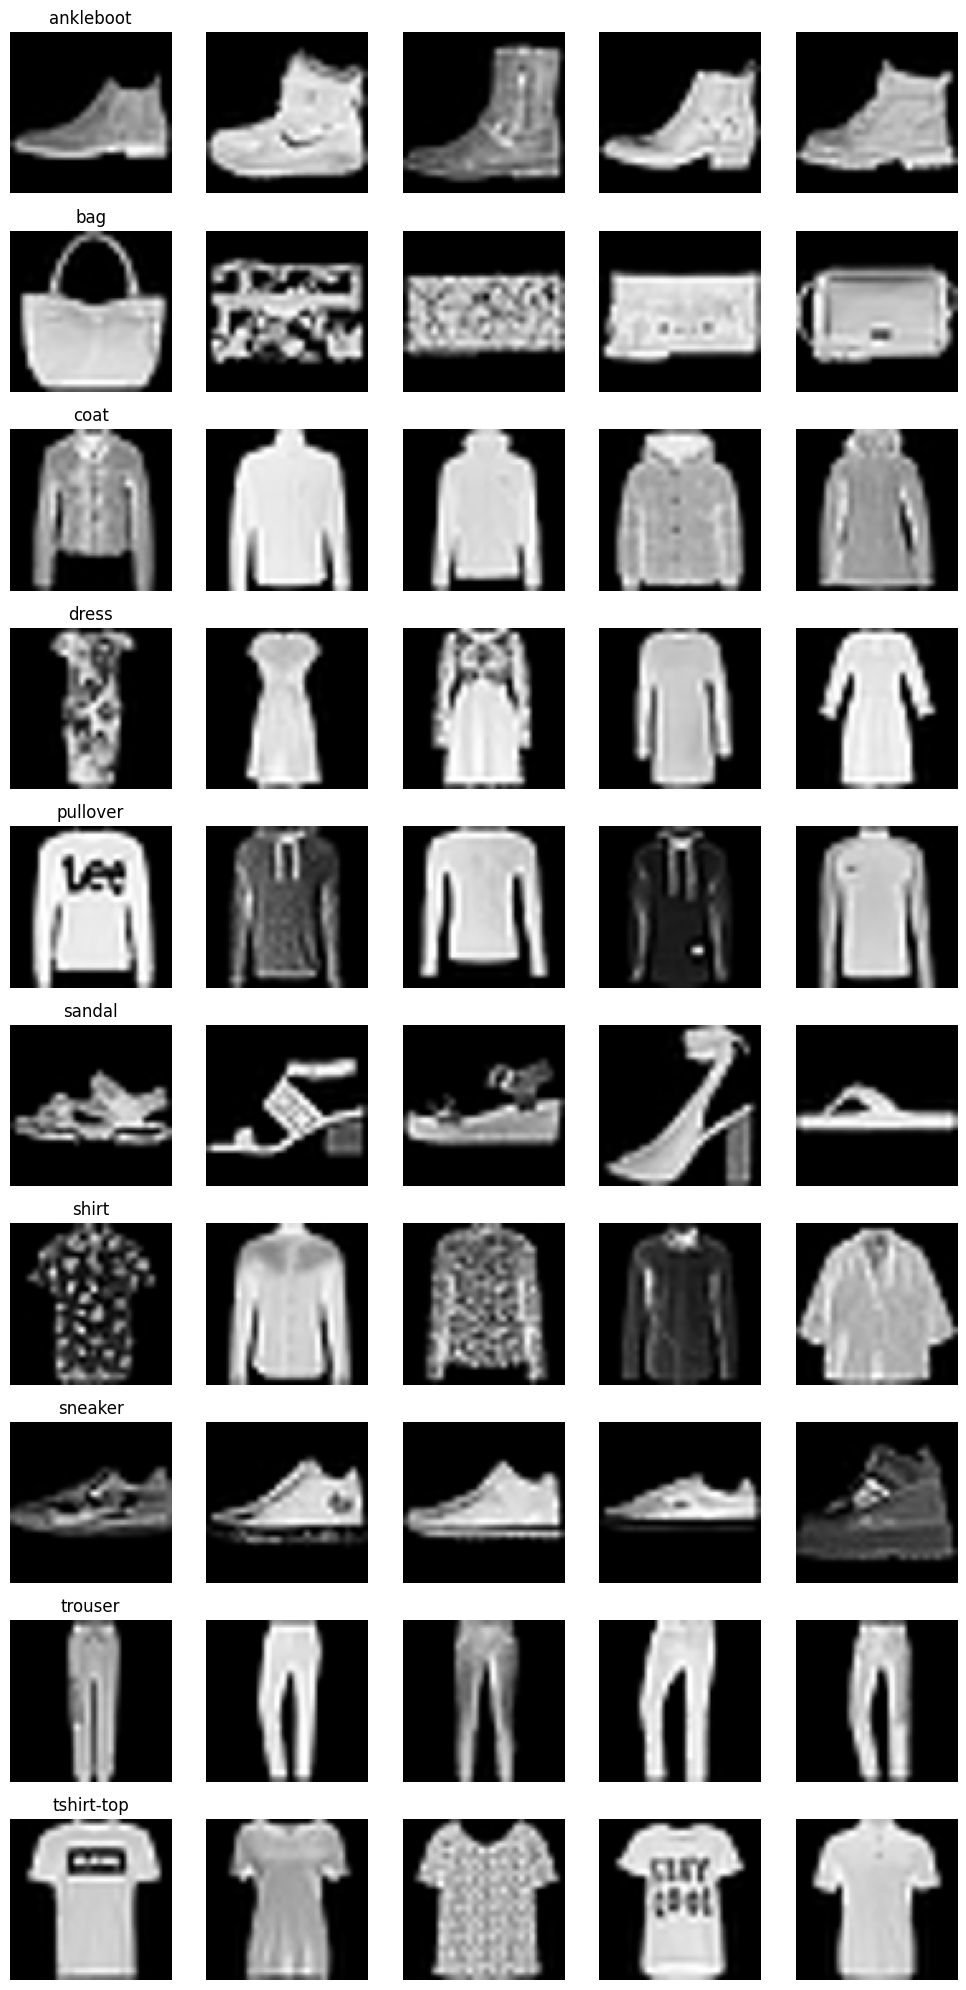

In [5]:
# Display sample images (5 per category)
fig, axes = plt.subplots(len(categories), 5, figsize=(10, len(categories) * 2))

for row, category in enumerate(categories):
    for col in range(5):
        if col < len(sample_images[category]):
            axes[row, col].imshow(sample_images[category][col], cmap="gray")
            axes[row, col].axis("off")
            axes[row, col].set_title(category if col == 0 else "")

plt.tight_layout()
plt.show()